In [2]:
from investesg import InvestESG
import numpy as np

# No ESG Invest; No preference for ESG; Risk free market

In [2]:

env = InvestESG(company_attributes=[{'capital':20,'climate_risk_exposure':0.1,'beta':0},
                                    {'capital':20,'climate_risk_exposure':0.1,'beta':0},
                                    {'capital':20,'climate_risk_exposure':0.1,'beta':0}],
                investor_attributes=[{'capital':20,'esg_preference':0.5},
                                     {'capital':20,'esg_preference':0.5},
                                     {'capital':20,'esg_preference':0.5}], 
                                    num_investors=3, initial_climate_event_probability=0.1,
                                    market_performance_baseline=1.05, market_performance_variance=0)

In [19]:
env.reset()
for i in range(100):
    # Company actions: set all values to 0
    company_actions = {
        f"company_{j}": np.array([0.0,0.0,0.0]) for j in range(env.num_companies)
    }

    # Investor actions: continuous values that sum to 1
    investor_actions = {f"investor_{i}": env.action_space(f"investor_{i}").sample() for i in range(env.num_investors)}

    # Set specific investor actions if needed
    investor_actions['investor_0'] = [1.0, 0.0, 0.0]
    investor_actions['investor_1'] = [0.0, 1.0, 0.0]
    investor_actions['investor_2'] = [0.0, 0.0, 1.0]

    actions = {**company_actions, **investor_actions}
    obs, rewards, terminations, truncations, infos = env.step(actions)

<Figure size 640x480 with 0 Axes>

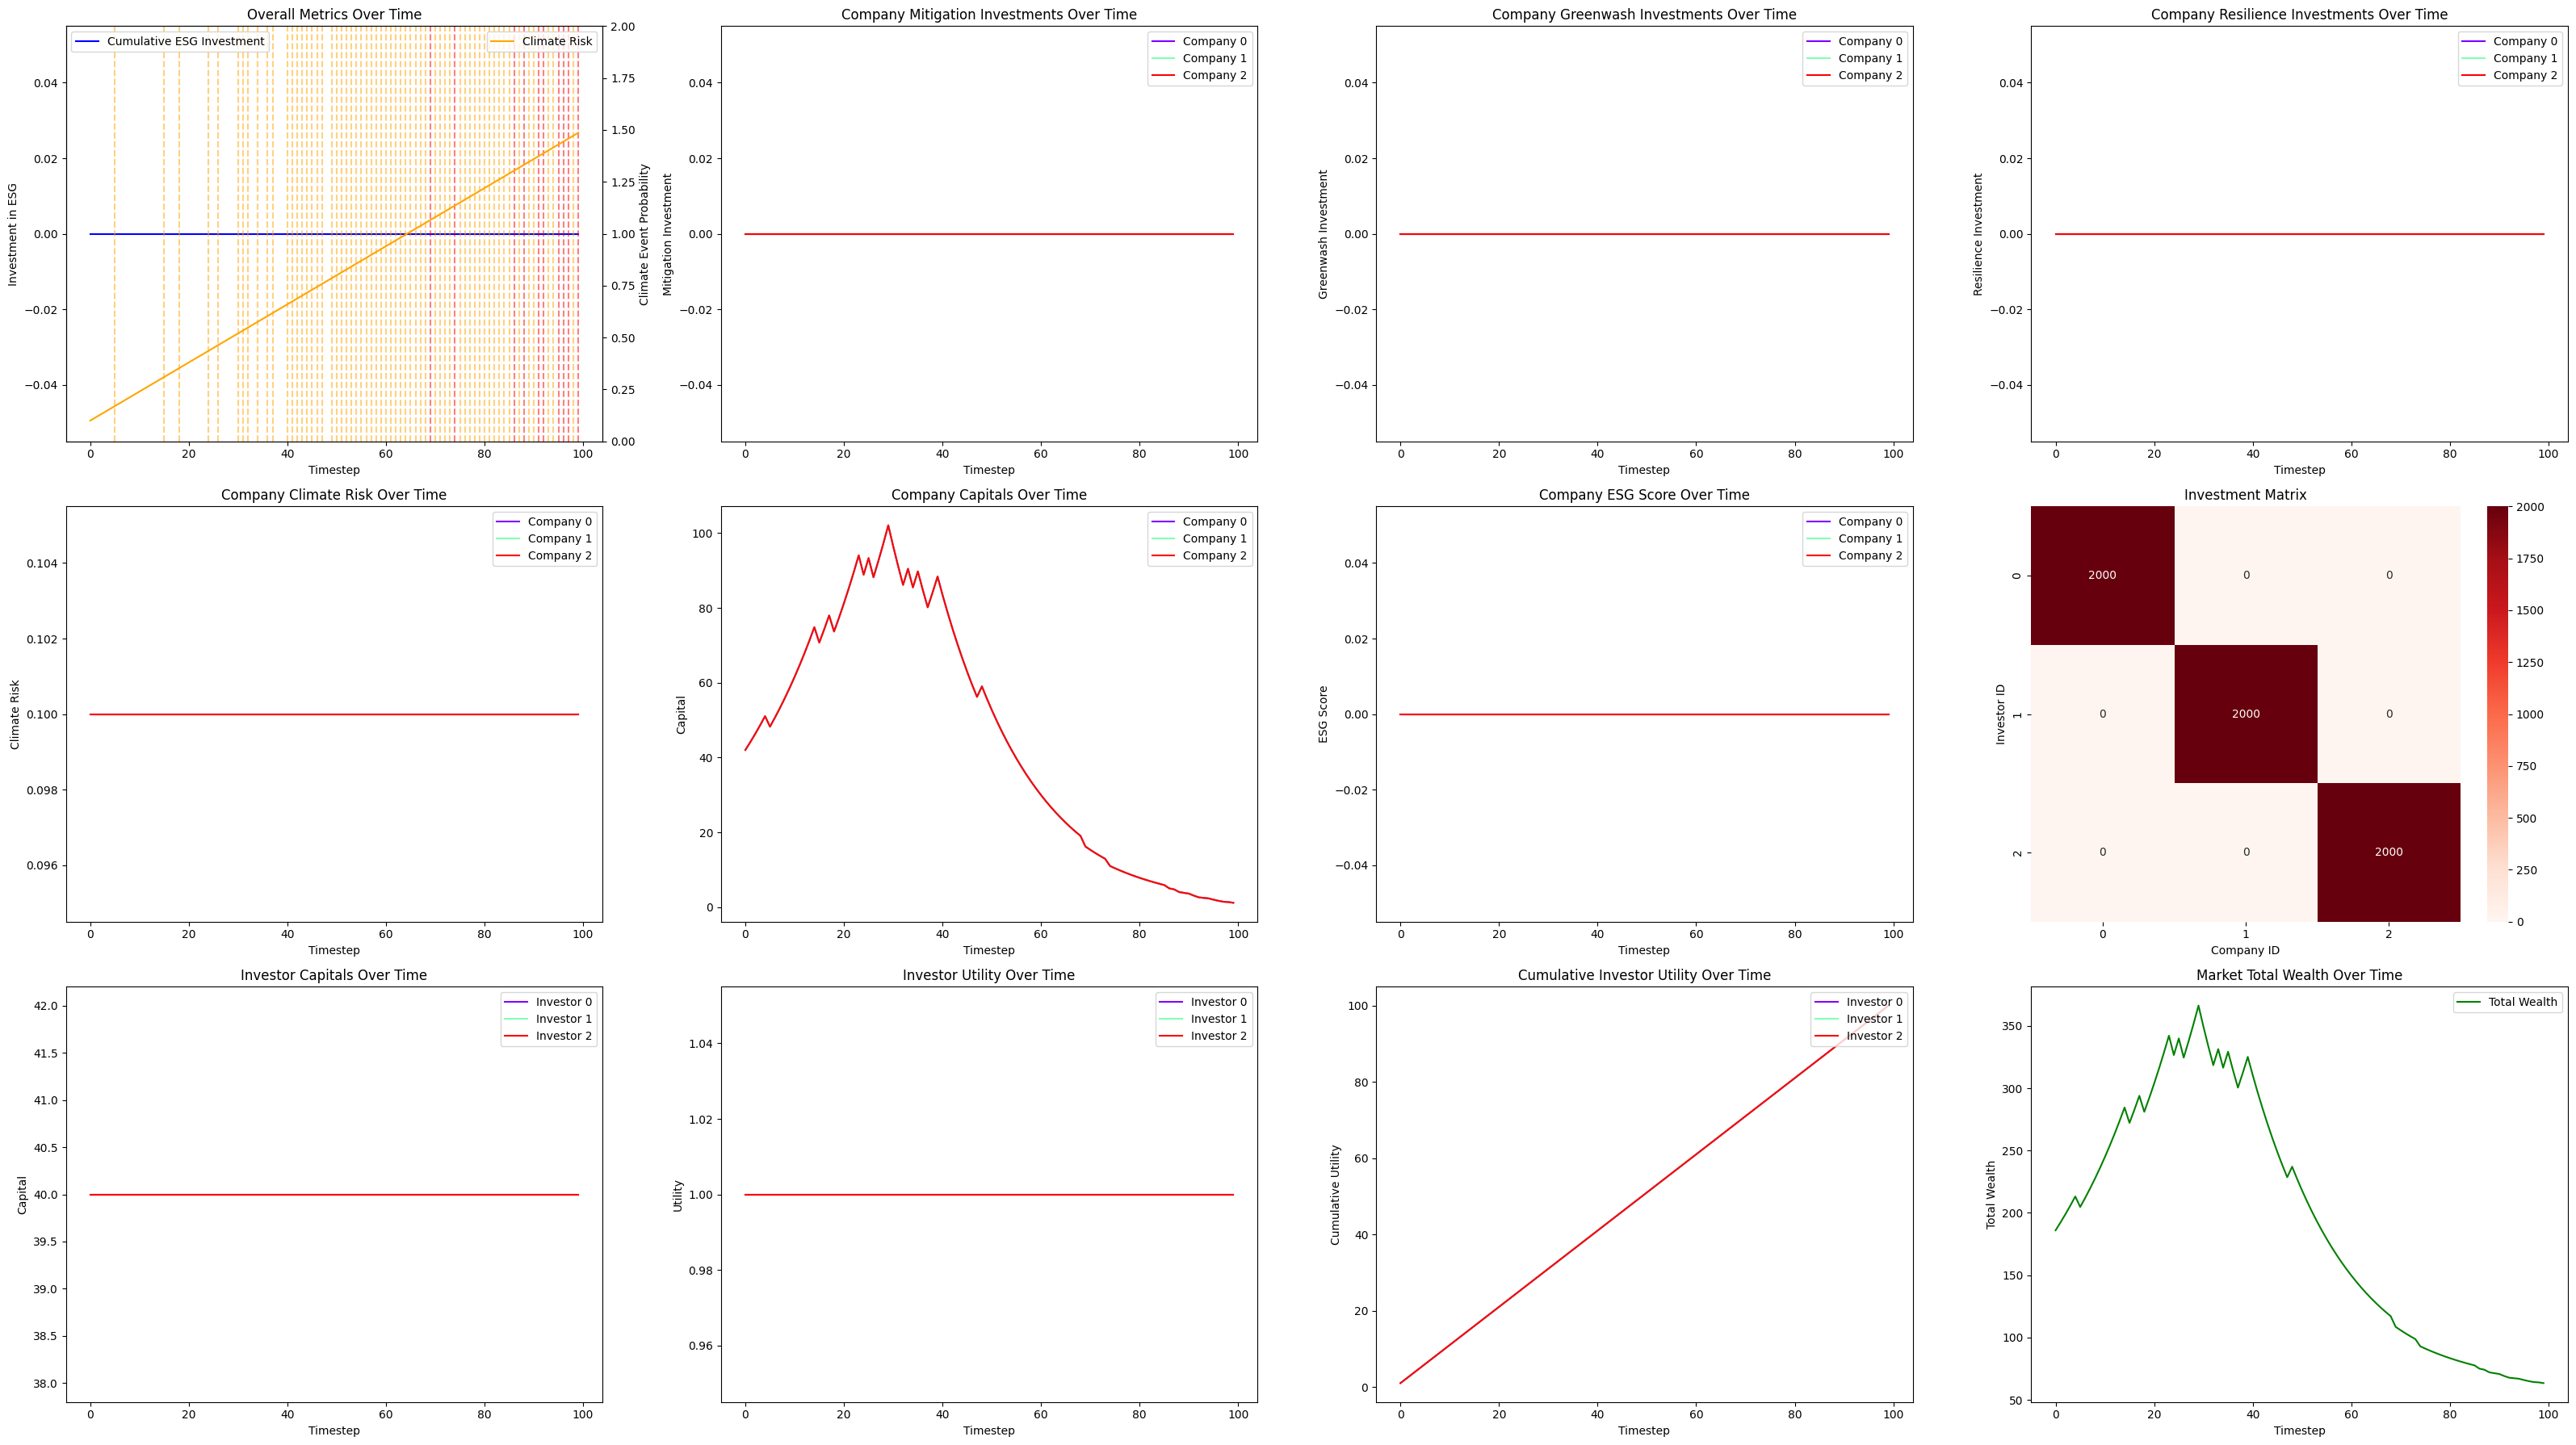

In [20]:
env.render()
env.fig

# One Company Invest in ESG every ten periods; No preference for ESG; Risk free market

<Figure size 640x480 with 0 Axes>

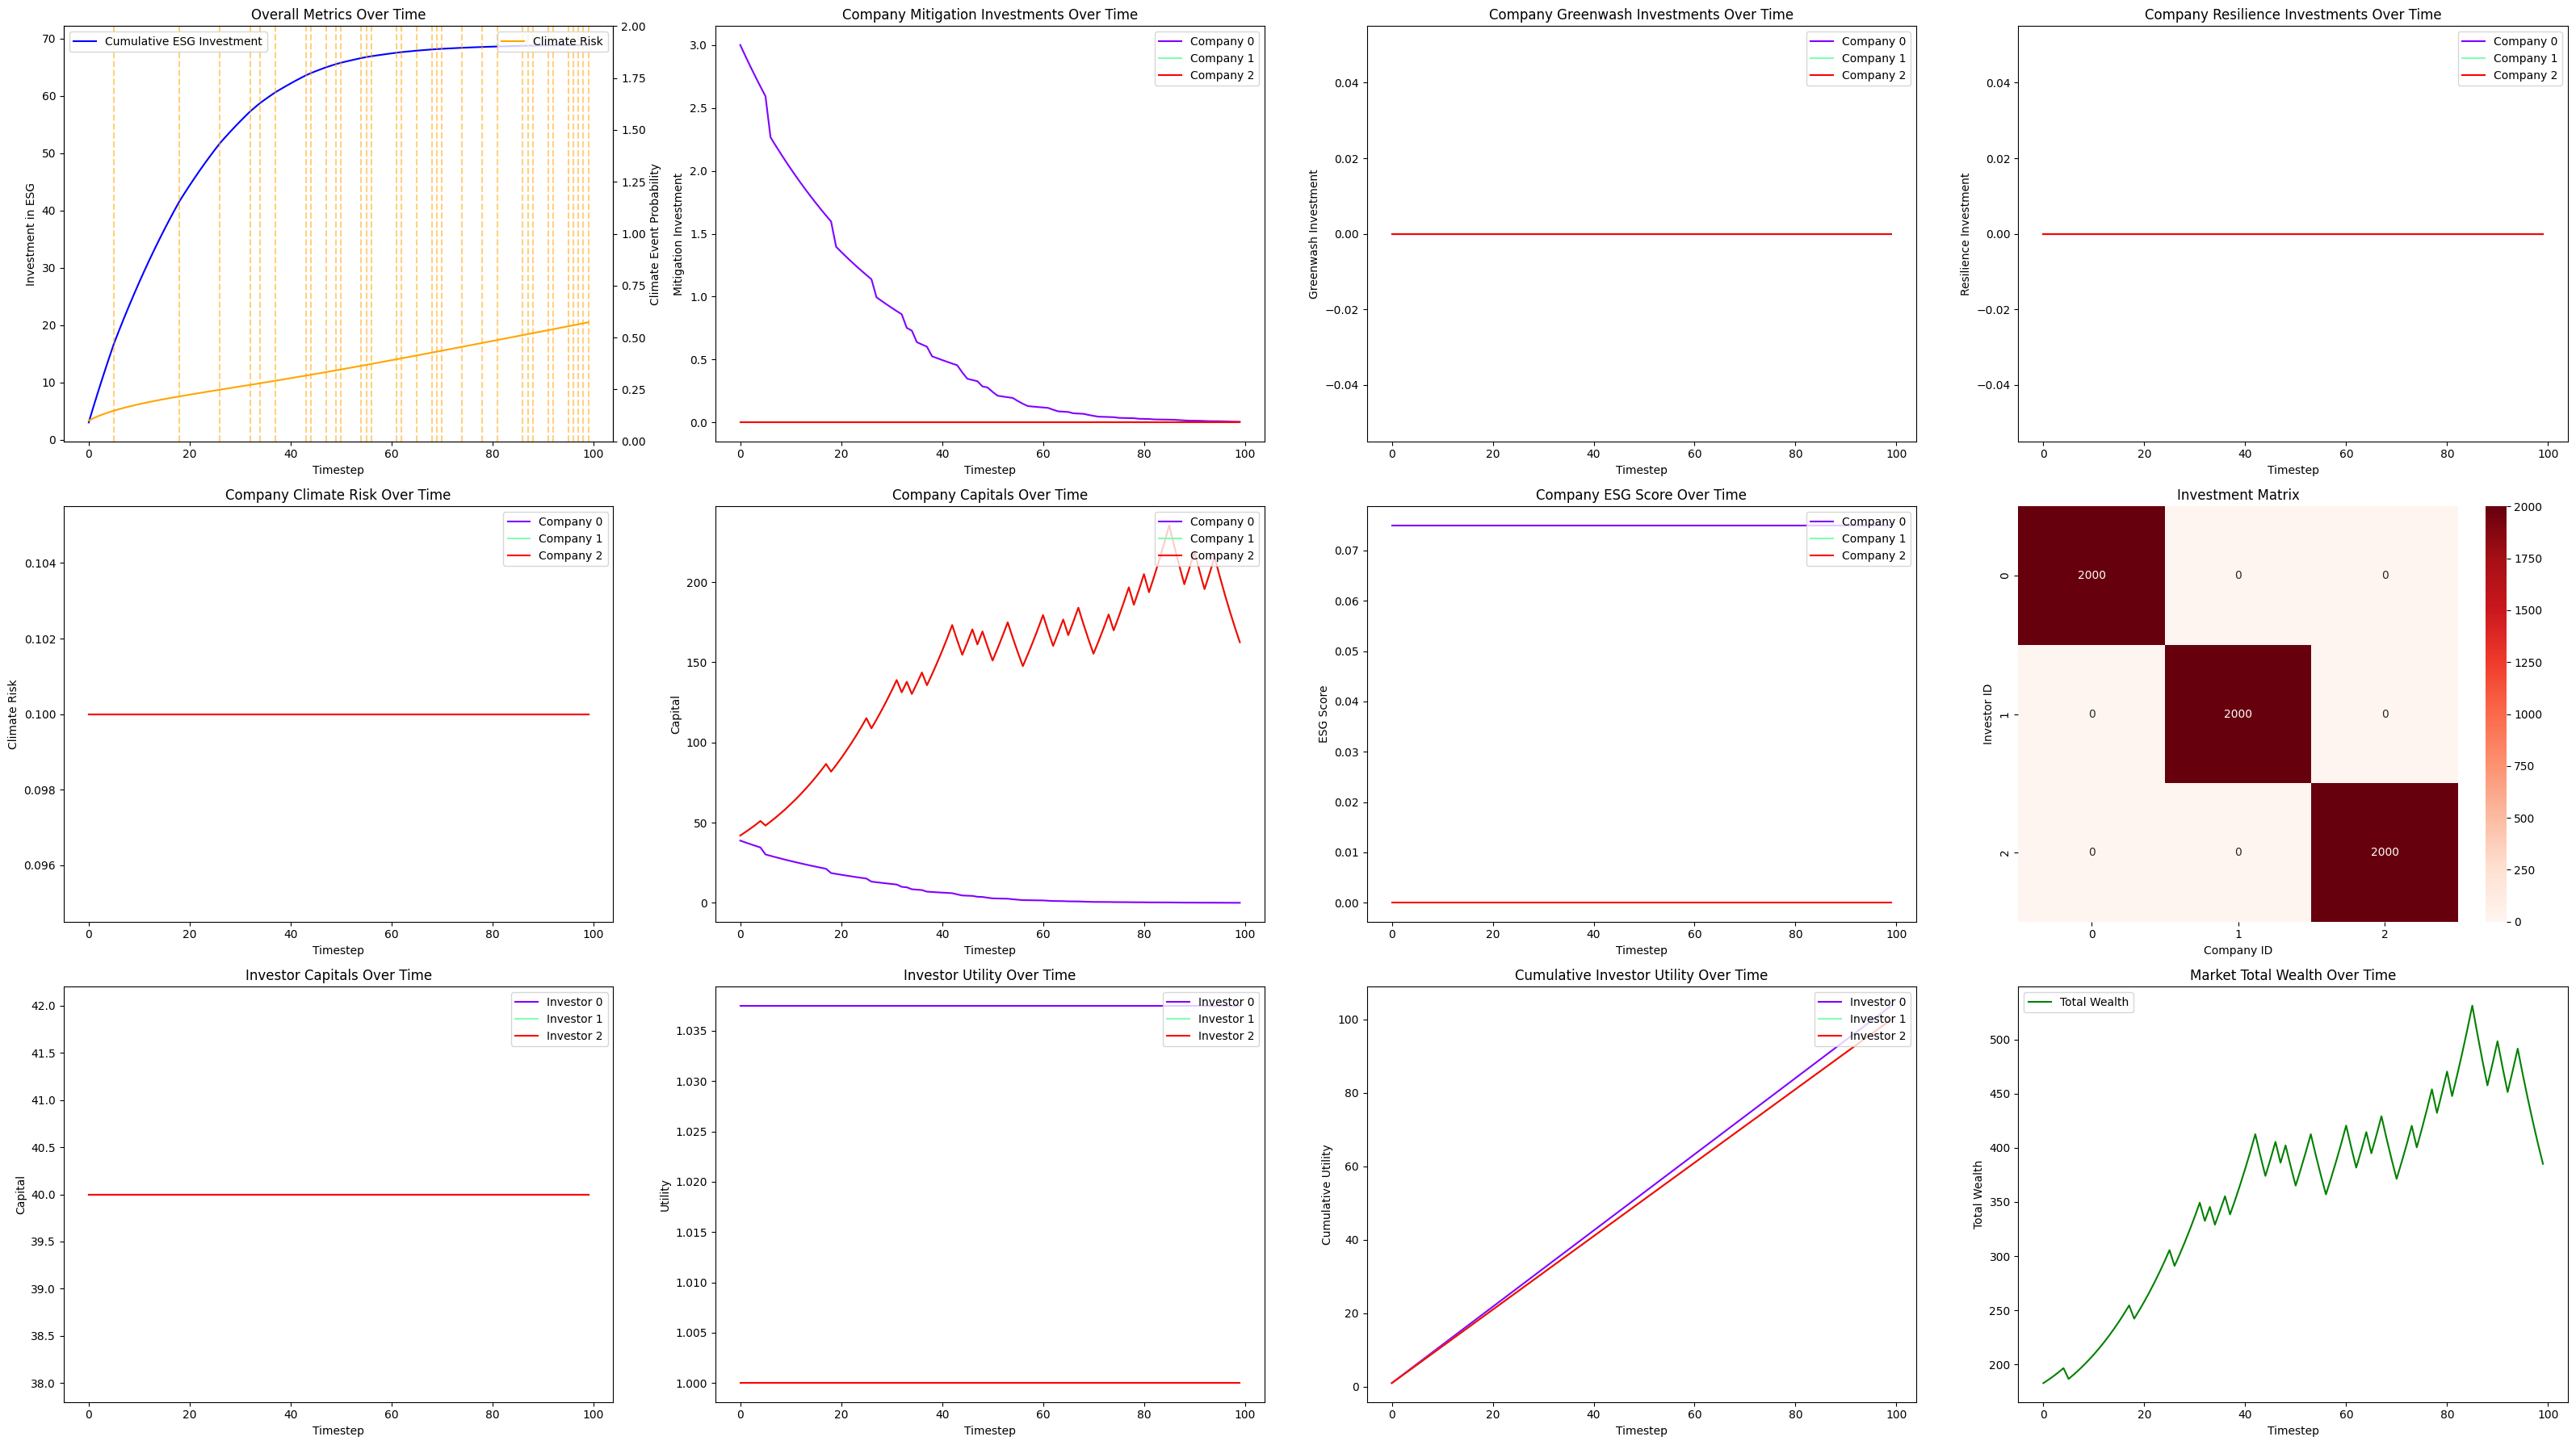

In [29]:
env.reset()
for i in range(100):
    company_actions = {f"company_{i}": env.action_space(f"company_{i}").sample() for i in range(env.num_companies)}
    # company invests in ESG every 10 steps, other companies never do
    # if i % 10 == 0:
    #     company_actions['company_0'] = np.array([0.05,0,0])
    # else:
    #     company_actions['company_0'] = np.array([0,0,0])

    company_actions['company_0'] = np.array([0.075,0,0])

    company_actions['company_1'] = np.array([0,0,0])
    company_actions['company_2'] = np.array([0,0,0])
    investor_actions = {f"investor_{i}": env.action_space(f"investor_{i}").sample() for i in range(env.num_investors)}
    # mask such that investor 0 only invests in company 0
    investor_actions['investor_0'] = [1, 0, 0]
    investor_actions['investor_1'] = [0, 1, 0]
    investor_actions['investor_2'] = [0, 0, 1]
    actions = {**company_actions, **investor_actions}
    obs, rewards, terminations, truncations, infos = env.step(actions)

env.render()
env.fig

In [30]:
env.history['market_total_wealth'][-1]

385.17115375896185

In [31]:
env.history['esg_investment'][-1]


[3.0,
 5.91375,
 8.7437296875,
 11.492347458984376,
 14.161942469538577,
 16.754786623539342,
 19.02125651965526,
 21.22256540625785,
 23.360586662370615,
 25.437139807370137,
 27.453992049450925,
 29.41285978957189,
 31.315410082164377,
 33.16326205384483,
 34.957988281339475,
 36.70111612979364,
 38.394129052604754,
 40.038467853885045,
 41.63553191462853,
 43.03156553672593,
 44.38746319218802,
 45.704378790055586,
 46.98343306448446,
 48.2257145285235,
 49.43228040047141,
 50.60415750360083,
 51.74234314001528,
 52.73725965944605,
 53.703572328943196,
 54.642103509192296,
 55.55365191800923,
 56.43899331007268,
 57.29888113711431,
 58.05053058392707,
 58.780570109143966,
 59.41871590912418,
 60.03851501735497,
 60.640494901224116,
 61.16670056721124,
 61.67777782030123,
 62.17416160236488,
 62.65627435069421,
 63.12452635750907,
 63.579316119128,
 63.97685921950315,
 64.32436158211857,
 64.6618732518088,
 64.98968146099544,
 65.2762268118507,
 65.5545339838689,
 65.79780924060928,


# One Company Invest in ESG every ten periods, the other one in greenwashing

<Figure size 640x480 with 0 Axes>

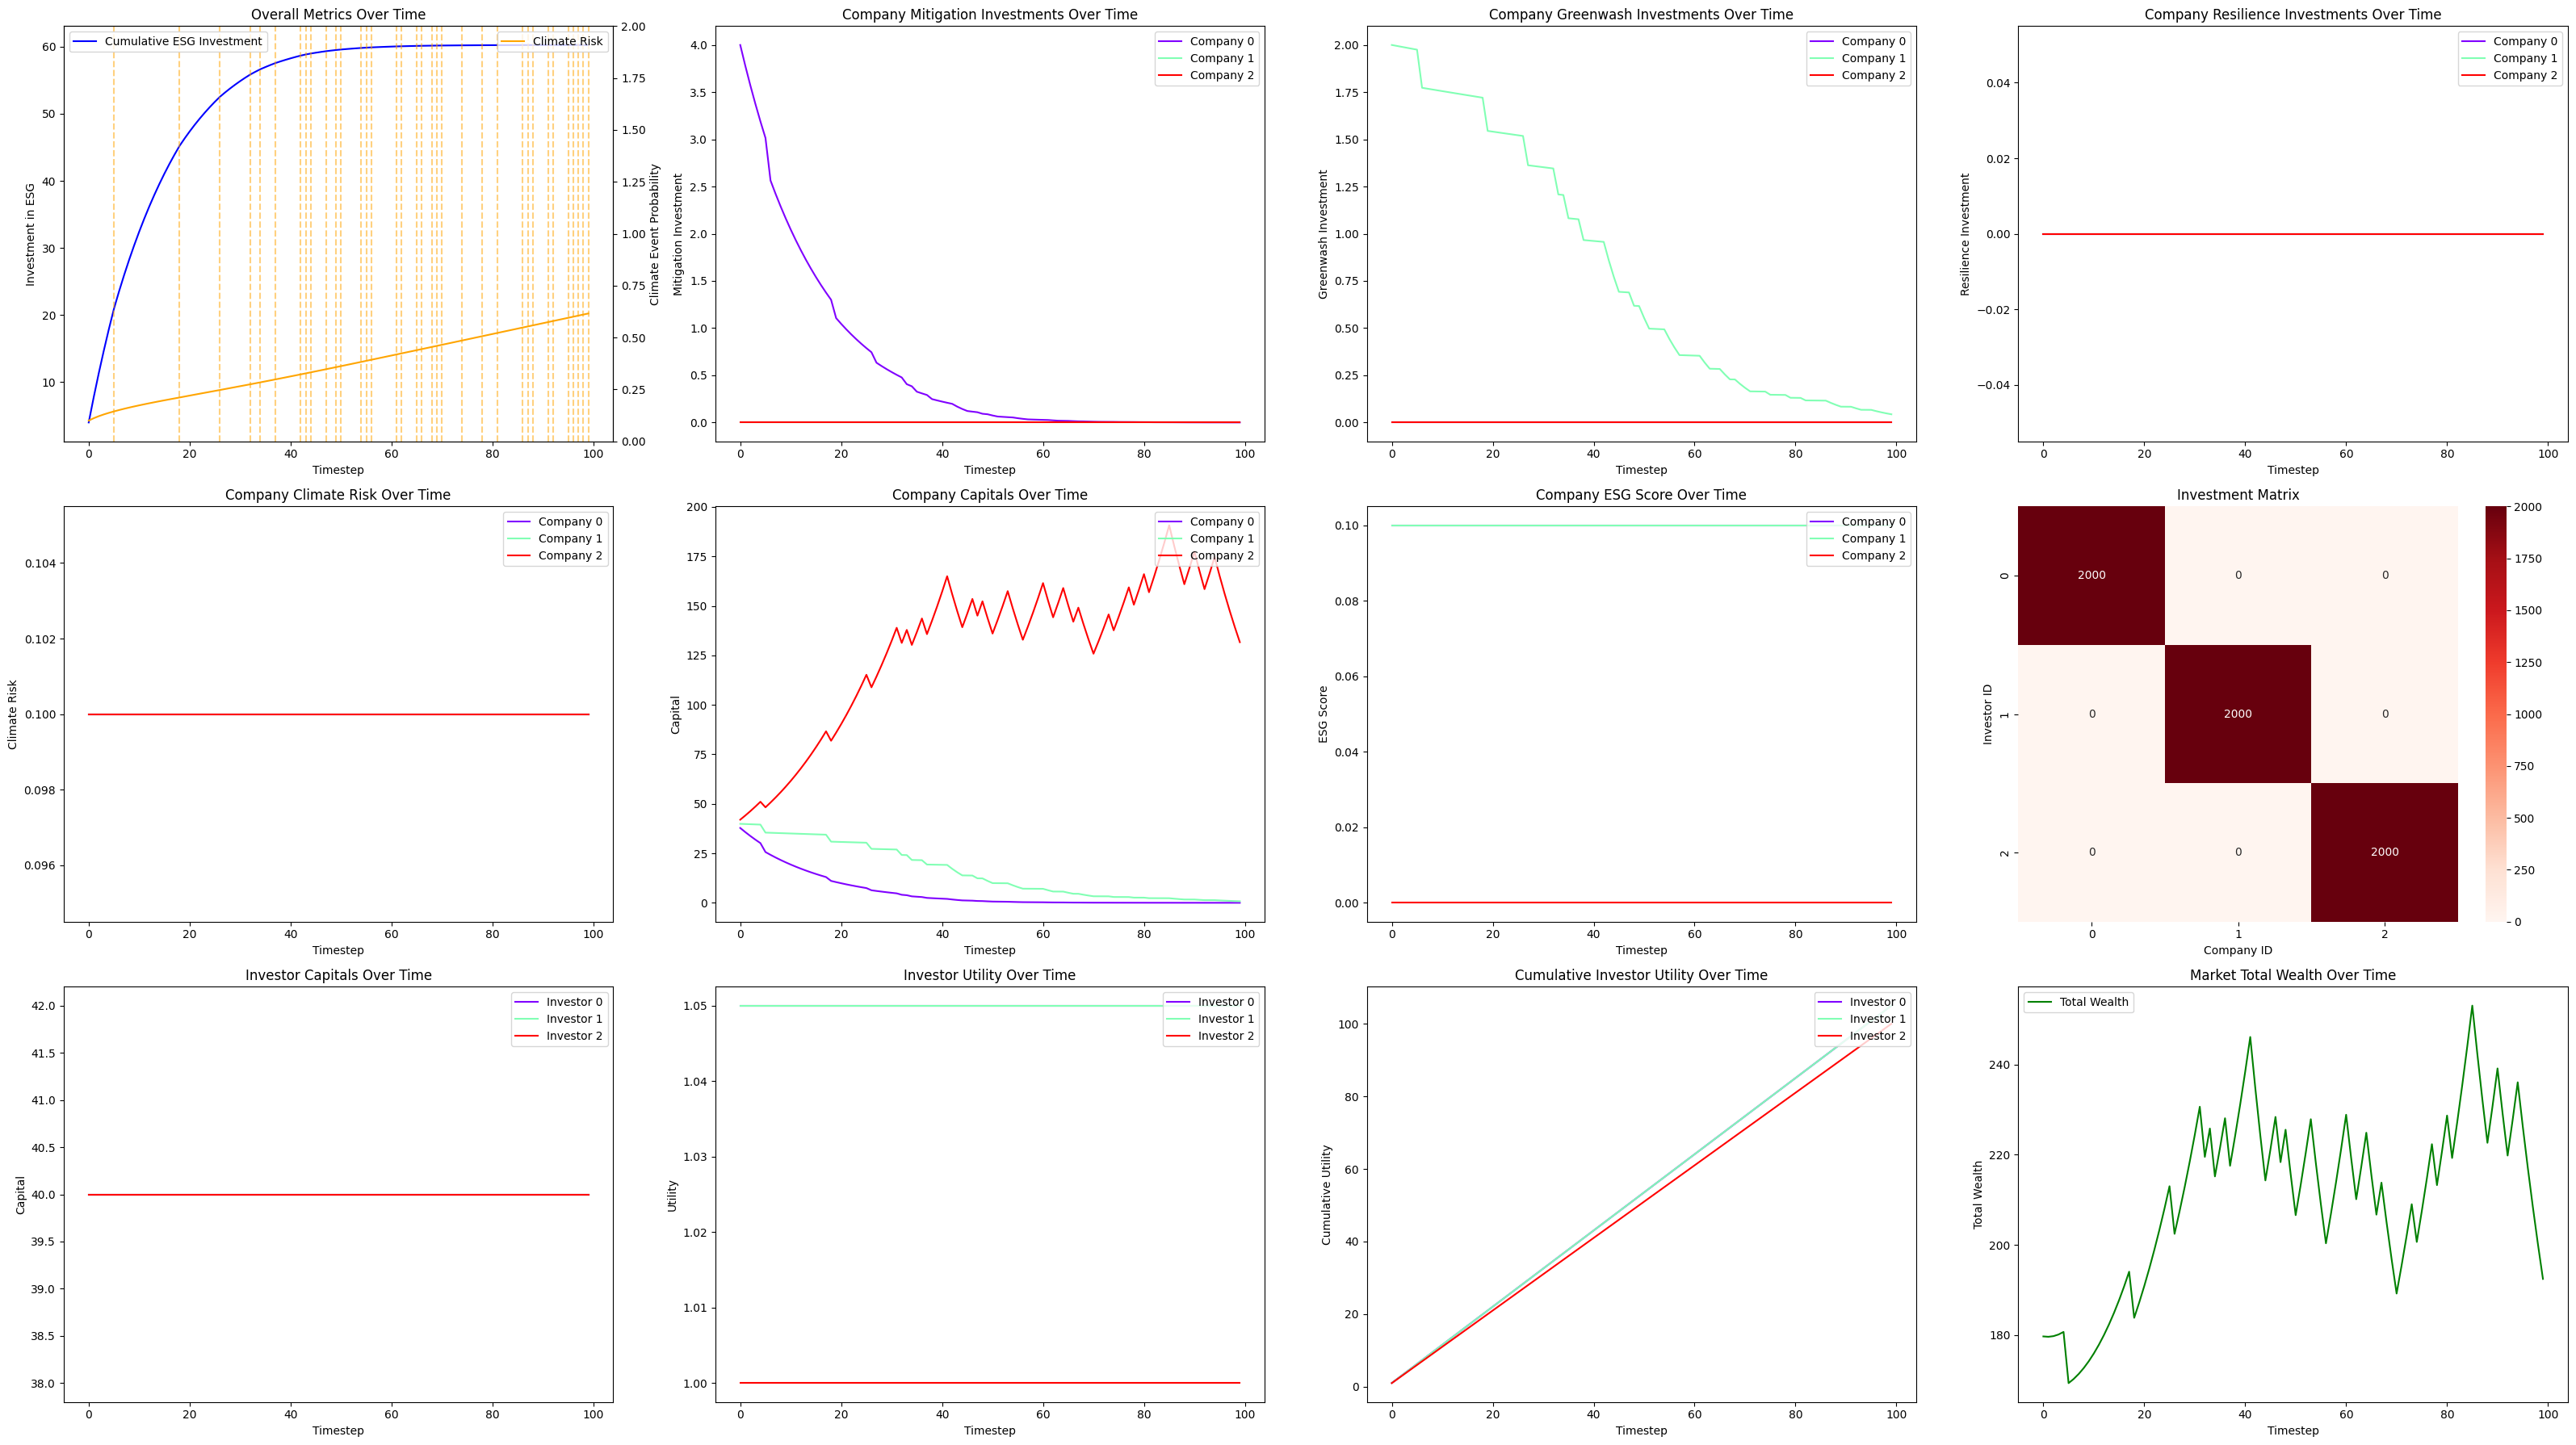

In [25]:
env.reset()
for i in range(100):
    company_actions = {f"company_{i}": env.action_space(f"company_{i}").sample() for i in range(env.num_companies)}
    # company invests in ESG every 10 steps, other companies never do
    # if i % 10 == 0:
    #     company_actions['company_0'] = np.array([0.05,0,0])
    # else:
    #     company_actions['company_0'] = np.array([0,0,0])

    # # company spends on greenwashing
    # if i % 10 == 0:
    #     company_actions['company_1'] = np.array([0,0.05,0])
    # else:
    #     company_actions['company_1'] = np.array([0,0,0])
    company_actions['company_0'] = np.array([0.1,0,0])
    company_actions['company_1'] = np.array([0,0.05,0])
    company_actions['company_2'] = np.array([0,0,0])
    investor_actions = {f"investor_{i}": env.action_space(f"investor_{i}").sample() for i in range(env.num_investors)}
    # mask such that investor 0 only invests in company 0
    investor_actions['investor_0'] = [1, 0, 0]
    investor_actions['investor_1'] = [0, 1, 0]
    investor_actions['investor_2'] = [0, 0, 1]
    actions = {**company_actions, **investor_actions}
    obs, rewards, terminations, truncations, infos = env.step(actions)

env.render()
env.fig

In [26]:
env.history['market_total_wealth'][-1]

192.4502759985002

# All Invest in mitigation

<Figure size 640x480 with 0 Axes>

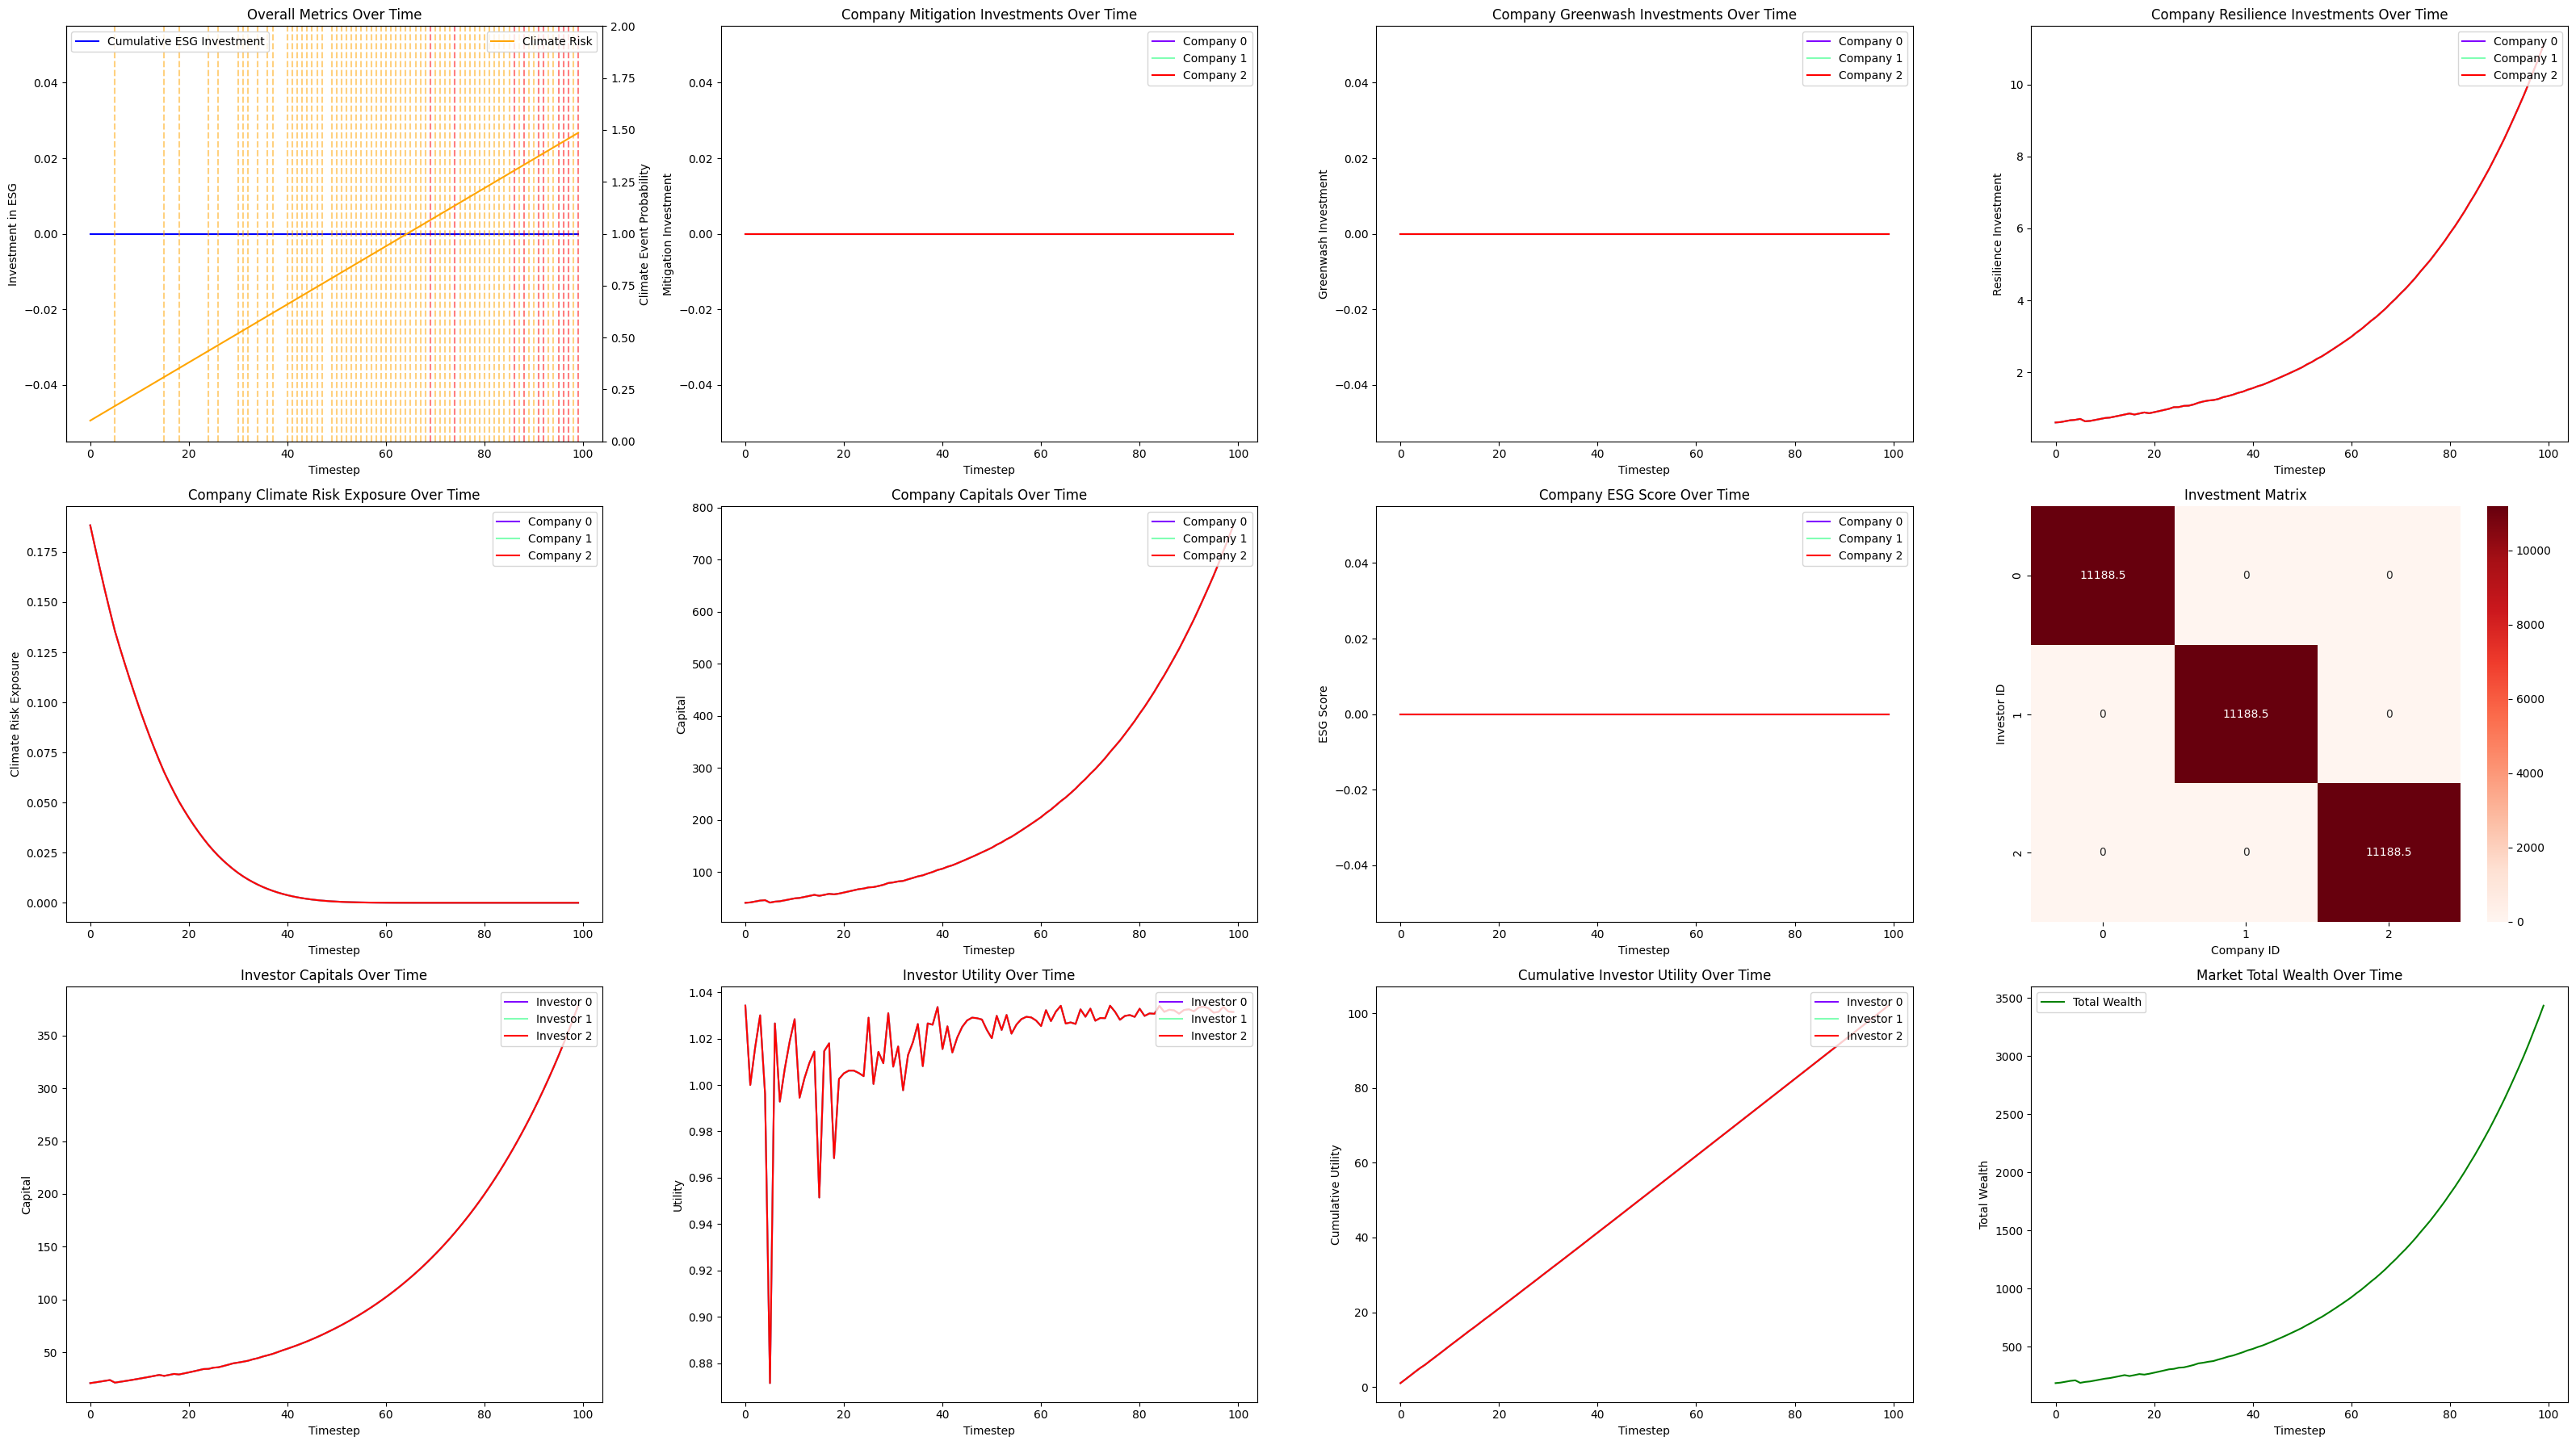

In [10]:
env.reset()
for i in range(100):
    company_actions = {f"company_{i}": env.action_space(f"company_{i}").sample() for i in range(env.num_companies)}
    # company invests in ESG every 10 steps, other companies never do
    # if i % 10 == 0:
    #     company_actions['company_0'] = np.array([0.05,0,0])
    # else:
    #     company_actions['company_0'] = np.array([0,0,0])

    # # company spends on greenwashing
    # if i % 10 == 0:
    #     company_actions['company_1'] = np.array([0,0.05,0])
    # else:
    #     company_actions['company_1'] = np.array([0,0,0])
    company_actions['company_0'] = np.array([0.0,0,0.015])
    company_actions['company_1'] = np.array([0.0,0,0.015])
    company_actions['company_2'] = np.array([0.0,0,0.015])
    investor_actions = {f"investor_{i}": env.action_space(f"investor_{i}").sample() for i in range(env.num_investors)}
    # mask such that investor 0 only invests in company 0
    investor_actions['investor_0'] = [1, 0, 0]
    investor_actions['investor_1'] = [0, 1, 0]
    investor_actions['investor_2'] = [0, 0, 1]
    actions = {**company_actions, **investor_actions}
    obs, rewards, terminations, truncations, infos = env.step(actions)

env.render()
env.fig

In [10]:
env.investors[0].utility


1.0075

In [11]:
env.history['market_total_wealth'][-1]


3432.653279600404

In [106]:
env.history['esg_investment'][-1]


503.5077130948417

In [107]:
env.history['company_capitals'][0][-1]


236.61632891951578

In [108]:
env.history['company_capitals'][2][-1]


236.61632891951578

# Add resilience investment


In [3]:
env = InvestESG(company_attributes=[{'capital':20,'climate_risk_exposure':0.2,'beta':0},
                                    {'capital':20,'climate_risk_exposure':0.2,'beta':0},
                                    {'capital':20,'climate_risk_exposure':0.2,'beta':0}],
                investor_attributes=[{'capital':20,'esg_preference':0.5},
                                     {'capital':20,'esg_preference':0.5},
                                     {'capital':20,'esg_preference':0.5}], 
                                    num_investors=3, initial_climate_event_probability=0.1,
                                    market_performance_baseline=1.05, market_performance_variance=0, allow_resilience_investment=True)


<Figure size 640x480 with 0 Axes>

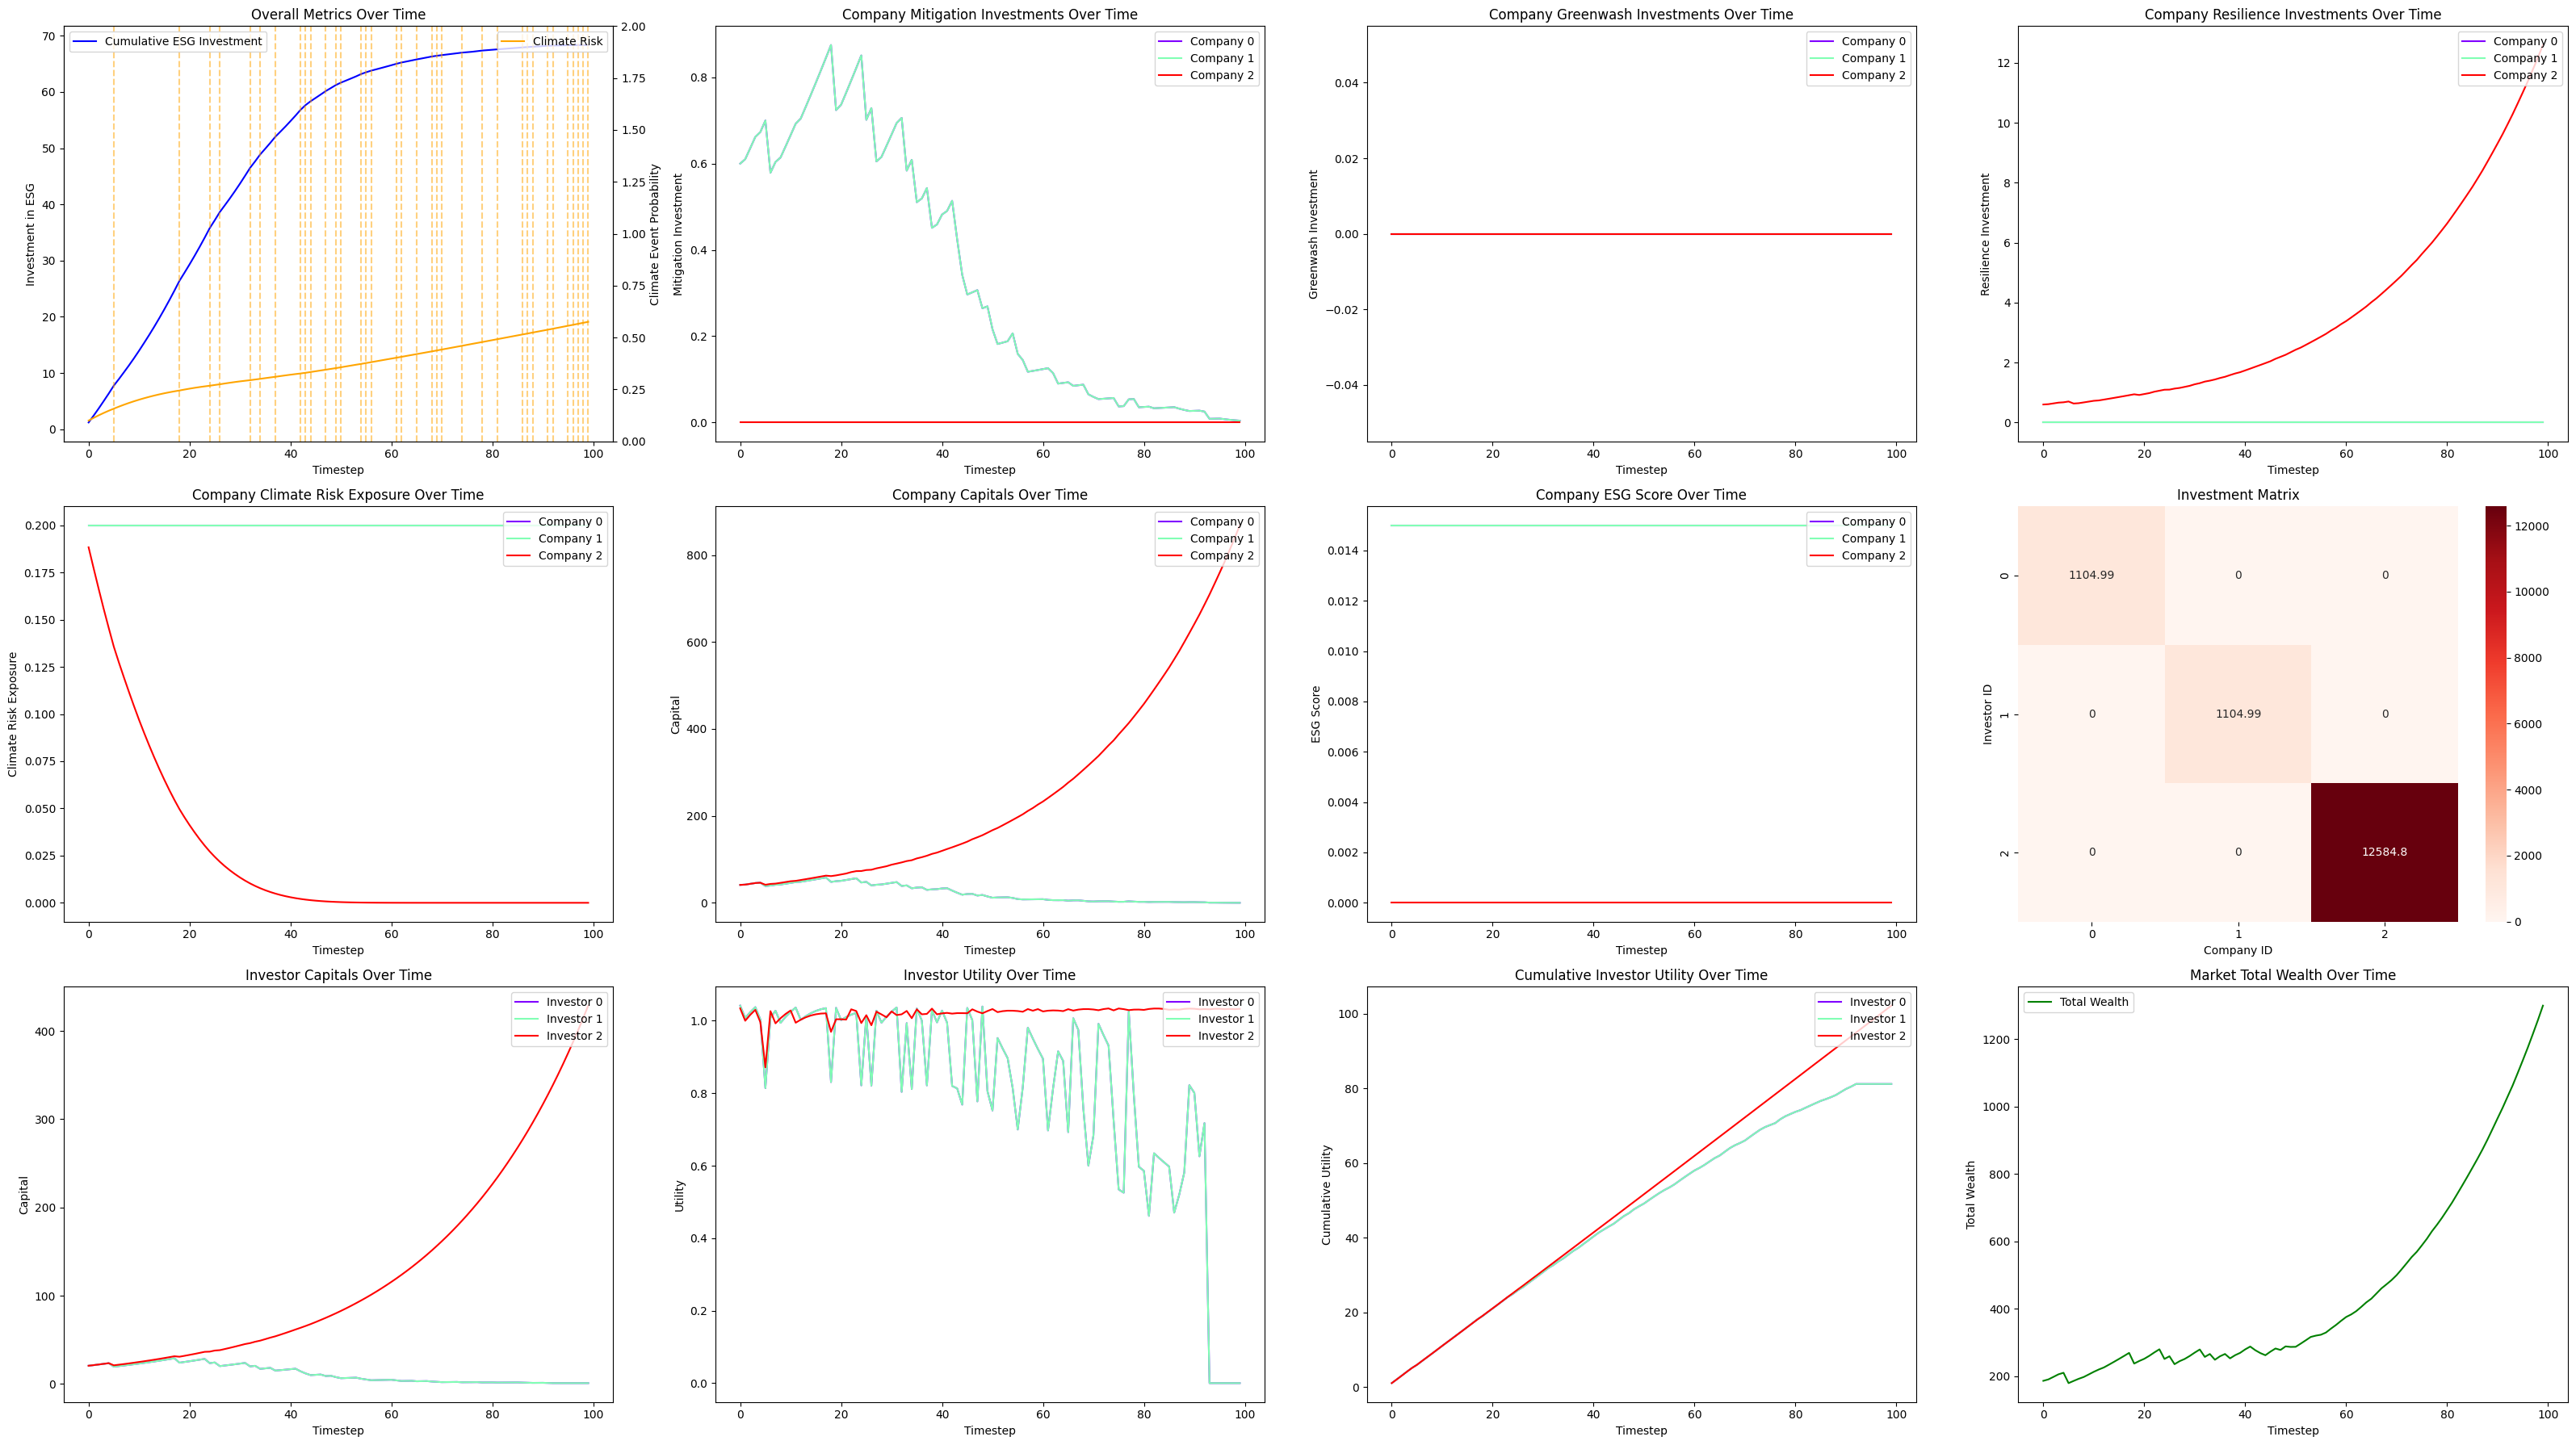

In [8]:
env.reset()
for i in range(100):
    company_actions = {f"company_{i}": env.action_space(f"company_{i}").sample() for i in range(env.num_companies)}
    # company invests in ESG every 10 steps, other companies never do
    # if i % 5 == 0:
    #     company_actions['company_0'] = np.array([0.2,0,0])
    # else:
    #     company_actions['company_0'] = np.array([0,0,0])

    # # company spends on greenwashing
    # if i % 5 == 0:
    #     company_actions['company_1'] = np.array([0,0.1,0])
    # else:
    #     company_actions['company_1'] = np.array([0,0,0])

    # # company spends on resilience investment
    # if i % 5 == 0:
    #     company_actions['company_2'] = np.array([0.1,0,0.1])
    # else:
    #     company_actions['company_2'] = np.array([0,0,0])
    company_actions['company_0'] = np.array([0.015,0,0])
    company_actions['company_1'] = np.array([0.015,0,0])
    company_actions['company_2'] = np.array([0,0,0.015])


    investor_actions = {f"investor_{i}": env.action_space(f"investor_{i}").sample() for i in range(env.num_investors)}
    # mask such that investor 0 only invests in company 0
    investor_actions['investor_0'] = [1, 0, 0]
    investor_actions['investor_1'] = [0, 1, 0]
    investor_actions['investor_2'] = [0, 0, 1]
    actions = {**company_actions, **investor_actions}
    obs, rewards, terminations, truncations, infos = env.step(actions)

env.render()
env.fig

In [9]:
env.history['market_total_wealth'][-1]

1299.5678066814082

In [101]:
env.history['esg_investment'][-1]

553.6457244028973

In [9]:
env.history['company_capitals'][2]

[41.37,
 42.078461250000004,
 43.8454372978125,
 45.63750921276258,
 46.421286528299696,
 44.025292860498304,
 45.84585493425595,
 47.671018090754224,
 44.51124573929531,
 42.4983498894347,
 44.02821947626581,
 45.82655168082792,
 47.65105370089628,
 48.46837185265198,
 50.34793315110531,
 48.6101942414889,
 50.22120775554009,
 52.125380621167345,
 50.56199730638608,
 52.13775153846784,
 54.07214296616036,
 56.037364237751355,
 58.03447127539434,
 59.030306166576594,
 57.741757080534086,
 60.394486179045096,
 59.23945327311727,
 60.830950596842484,
 62.921391842284336,
 65.04800763788258,
 64.14091232467901,
 63.81431124454509,
 63.536736399807914,
 65.01162850083087,
 64.47452537733528,
 66.9249998330945,
 69.11789307737799,
 68.75632074277134,
 71.2291347461858,
 73.49859848624267,
 75.81036829689648,
 79.20014316106518,
 79.13358381794653,
 79.34847063028054,
 79.60921715691244,
 83.15403967242104,
 85.61939303120145,
 85.95914180415528,
 89.55823833063558,
 90.05445134860594,
 91.6

In [103]:
env.history['company_capitals'][0][-1]


224.78551247354028

# A pure Random Case

In [ ]:
env = InvestESG(company_attributes=[{'capital':10000,'climate_risk_exposure':0.5,'beta':0},
                                    {'capital':10000,'climate_risk_exposure':0.5,'beta':0},
                                    {'capital':10000,'climate_risk_exposure':0.5,'beta':0}],
                investor_attributes=[{'capital':10000,'esg_preference':0.5},
                                     {'capital':10000,'esg_preference':0.5},
                                     {'capital':10000,'esg_preference':0.5}], 
                                    num_investors=3, initial_climate_event_probability=0.1,
                                    market_performance_baseline=1.05, market_performance_variance=0)

env.reset()
for i in range(100):
    company_actions = {f"company_{i}": env.action_space(f"company_{i}").sample() for i in range(env.num_companies)}
    investor_actions = {f"investor_{i}": env.action_space(f"investor_{i}").sample() for i in range(env.num_investors)}
    actions = {**company_actions, **investor_actions}
    obs, rewards, terminations, truncations, infos = env.step(actions)

env.render()
env.fig